## DeepAR version 0.1

This is based off of <a href = "https://medium.com/@julsimon/predicting-world-temperature-with-time-series-and-deepar-on-amazon-sagemaker-e371cf94ddb5">this tutorial</a> that I found online. Thanks <a href = "https://twitter.com/julsimon"> Julien Simon</a>(that is what the JS stands for in the name)! Here is a link to <a href = "https://github.com/juliensimon/dlnotebooks/blob/master/sagemaker/04-DeepAR-temperatures.ipynb">his original notebook</a> on his GitHub page.

In [41]:
# Just a dictionary that has the month name as a key and month number as value
months_to_number = {v: k for k,v in enumerate(calendar.month_name)}

In [61]:
# Our model will predict temperature for the next 'prediction_length' 5 minute intervals
prediction_length = 30
freq = '5min'
bucket = '#####'

In [2]:
import csv, boto3, json, sagemaker
import numpy as np
import pandas as pd

In [3]:
data_key = 'Bainbridge_Departures_Master.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(data_location, parse_dates = ["timestamps"], index_col = "timestamps")

In [7]:
df_first_year = 2013
df_last_year = 2017

`dataset` is a dictionary that stores month name and year as a key (ex `April 2014`) and the values is a list of seconds late for that entire month

In [11]:
import calendar

dataset = {}

for year in range (df_first_year, df_last_year + 1):
    for month in range(1,13):
        index = "{}-{}".format(year, month)
        key = "{} {}".format(calendar.month_name[month], year)
        dataset[key] = list(df[index]["seconds_late"])

In [16]:
# According to https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html
# - remove the last 'prediction_length' points from each time series
# - use the full data set for testing
# - no need to shuffle the training set: dictionaries are not ordered :)

trainingSet = dataset.copy()
trainingSet[year] = { year: dataset[year][:-prediction_length] for year in dataset.keys() }

testSet = dataset.copy()

In [40]:
train_key      = 'bainbridge_deepar_training.json'
test_key       = 'bainbridge_deepar_test.json'

def writeDataset(filename, data):
    file=open(filename,'w')
    for key in dataset.keys():
        # One JSON sample per line
        month, year = key.split(" ")
        line = "\"start\":\"{}-{}-01 00:00:00\",\"target\":{}".format(year, months_to_number[month],dataset[key])
        file.write('{'+line+'}\n')

In [21]:
writeDataset(train_key, trainingSet)        
writeDataset(test_key, testSet)

### Uploading training set and test set to S3

In [23]:
prefix         = 'sagemaker/deepar-bainbridge-departures'

train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')
output_prefix  = '{}/{}'.format(prefix, 'output')

In [24]:
sagemaker_session = sagemaker.Session()
role              = sagemaker.get_execution_role()
region            = boto3.Session().region_name

train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)
output_path = 's3://{}/{}'.format(bucket, output_prefix)

print(train_path)
print(test_path)
print(output_path)

s3://example-bucket-99/sagemaker/deepar-bainbridge-departures/train/bainbridge_deepar_training.json
s3://example-bucket-99/sagemaker/deepar-bainbridge-departures/test/bainbridge_deepar_test.json
s3://example-bucket-99/sagemaker/deepar-bainbridge-departures/output


### Configure training job

In [25]:
containers = {
    'us-east-1': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest',
    'us-east-2': '566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:latest',
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest',
    'eu-west-1': '224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:latest'
}

image_name = containers[region]

In [29]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.8xlarge',
    base_job_name='bainbridge-departures-predictor',
    output_path=output_path
)

In [30]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html

hyperparameters = {
    "time_freq": freq,
    "context_length": prediction_length,
    "prediction_length": prediction_length, # number of data points to predict
    "num_cells": "40",
    "num_layers": "2",
    "likelihood": "gaussian",
    "epochs": "250",
    "mini_batch_size": "32",
    "learning_rate": "0.00001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10" # stop if loss hasn't improved in 10 epochs
}

estimator.set_hyperparameters(**hyperparameters)

### Run training job

In [31]:
print(train_path)
print(test_path)
print(output_path)

data_channels = {"train": train_path, "test": test_path}

s3://example-bucket-99/sagemaker/deepar-bainbridge-departures/train/bainbridge_deepar_training.json
s3://example-bucket-99/sagemaker/deepar-bainbridge-departures/test/bainbridge_deepar_test.json
s3://example-bucket-99/sagemaker/deepar-bainbridge-departures/output


In [33]:
%%time

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: bainbridge-departures-predictor-2019-04-10-17-58-57-334


2019-04-10 17:58:57 Starting - Starting the training job...
2019-04-10 17:58:58 Starting - Launching requested ML instances.........
2019-04-10 18:00:29 Starting - Preparing the instances for training......
2019-04-10 18:01:57 Downloading - Downloading input data
2019-04-10 18:01:57 Training - Downloading the training image..
Arguments: train
[04/10/2019 18:02:03 INFO 140054916126528] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[04/10/2019 18:02:03 INFO 14


2019-04-10 18:02:00 Training - Training image download completed. Training in progress.[04/10/2019 18:02:18 INFO 140054916126528] Epoch[10] Batch[5] avg_epoch_loss=58.571930
[04/10/2019 18:02:18 INFO 140054916126528] Epoch[10] Batch [5]#011Speed: 499.11 samples/sec#011loss=58.571930
[04/10/2019 18:02:18 INFO 140054916126528] Epoch[10] Batch[10] avg_epoch_loss=81.109534
[04/10/2019 18:02:18 INFO 140054916126528] Epoch[10] Batch [10]#011Speed: 401.89 samples/sec#011loss=108.154660
[04/10/2019 18:02:18 INFO 140054916126528] processed a total of 330 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1230.7898998260498, "sum": 1230.7898998260498, "min": 1230.7898998260498}}, "EndTime": 1554919338.449434, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1554919337.218352}

[04/10/2019 18:02:18 INFO 140054916126528] #throughput_metric: host=algo-1, train throughput=268.097594537 records/second
[04/10/2019 18:02:18 INFO 14005491

[04/10/2019 18:02:27 INFO 140054916126528] Epoch[19] Batch[5] avg_epoch_loss=13.163821
[04/10/2019 18:02:27 INFO 140054916126528] Epoch[19] Batch [5]#011Speed: 542.52 samples/sec#011loss=13.163821
[04/10/2019 18:02:28 INFO 140054916126528] Epoch[19] Batch[10] avg_epoch_loss=14.028047
[04/10/2019 18:02:28 INFO 140054916126528] Epoch[19] Batch [10]#011Speed: 500.50 samples/sec#011loss=15.065118
[04/10/2019 18:02:28 INFO 140054916126528] processed a total of 322 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1094.552993774414, "sum": 1094.552993774414, "min": 1094.552993774414}}, "EndTime": 1554919348.304388, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1554919347.209609}

[04/10/2019 18:02:28 INFO 140054916126528] #throughput_metric: host=algo-1, train throughput=294.161722029 records/second
[04/10/2019 18:02:28 INFO 140054916126528] #progress_metric: host=algo-1, completed 8 % of epochs
[04/10/2019 18:02:28 INFO 14

[04/10/2019 18:02:37 INFO 140054916126528] Epoch[29] Batch[0] avg_epoch_loss=8.664924
[04/10/2019 18:02:38 INFO 140054916126528] Epoch[29] Batch[5] avg_epoch_loss=23885.497210
[04/10/2019 18:02:38 INFO 140054916126528] Epoch[29] Batch [5]#011Speed: 480.98 samples/sec#011loss=23885.497210
[04/10/2019 18:02:38 INFO 140054916126528] processed a total of 299 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1132.4779987335205, "sum": 1132.4779987335205, "min": 1132.4779987335205}}, "EndTime": 1554919358.612521, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1554919357.479716}

[04/10/2019 18:02:38 INFO 140054916126528] #throughput_metric: host=algo-1, train throughput=263.992221462 records/second
[04/10/2019 18:02:38 INFO 140054916126528] #progress_metric: host=algo-1, completed 12 % of epochs
[04/10/2019 18:02:38 INFO 140054916126528] loss did not improve
[04/10/2019 18:02:38 INFO 140054916126528] Loading parameters from 

### Deploy model

In [34]:
%%time

job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    #instance_type='ml.m4.xlarge',
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: bainbridge-departures-predictor-2019-04-10-17-58-57-334
INFO:sagemaker:Creating endpoint-config with name bainbridge-departures-predictor-2019-04-10-17-58-57-334
INFO:sagemaker:Creating endpoint with name bainbridge-departures-predictor-2019-04-10-17-58-57-334


---------------------------------------------------------------------------!CPU times: user 447 ms, sys: 11.1 ms, total: 458 ms
Wall time: 6min 20s


In [72]:
predictor = sagemaker.predictor.RealTimePredictor(
    endpoint_name,
    sagemaker_session=sagemaker_session, 
    content_type="application/json")

In [36]:
q1 = '0.1'         # compute p10 quantile
q2 = '0.9'         # compute p90 quantile
num_samples = 100  # predict 100 sample series
    
def buildPredictionData(month, year, data):
    month_delays = dataset["{} {}".format(month, year)]
    s = {"start": "{}-{}-01 00:00:00".format(year, months_to_number[month]), "target": month_delays}
    series = []
    series.append(s)
    configuration = {
        "output_types": ["mean", "quantiles", "samples"],
        "num_samples": num_samples,
        "quantiles": [q1, q2]
    }
    http_data = {
        "instances": series, 
        "configuration": configuration
    }
    return json.dumps(http_data)

### Get predicted series from response

In [38]:
def getPredictedSeries(result):
    import random
    json_result = json.loads(result)
    y_data      = json_result['predictions'][0]
    y_mean      = y_data['mean']
    y_q1        = y_data['quantiles'][q1]
    y_q2        = y_data['quantiles'][q2]
    y_sample    = y_data['samples'][random.randint(0, num_samples)]

    #print("Mean: %s\n" % y_mean)
    #print("Quartile %s: %s\n" % (q1, y_q1))
    #print("Quartile %s: %s\n" % (q2, y_q2))
    return y_mean, y_q1, y_q2, y_sample

### Plot predicted series and ground truth

In [73]:
def plotSeries(result, truth=False, truth_data=None, truth_label=None):
    x = range(0,prediction_length)
    y_mean, y_q1, y_q2, y_sample = getPredictedSeries(result)
    plt.gcf().clear()
    mean_label,   = plt.plot(x, y_mean, label='mean')
    q1_label,     = plt.plot(x, y_q1, label=q1)
    q2_label,     = plt.plot(x, y_q2, label=q2)
    sample_label, = plt.plot(x, y_sample, label='sample')

    if truth:
        ground_truth, = plt.plot(x, truth_data, label=truth_label)
        plt.legend(handles=[ground_truth, q2_label, mean_label, q1_label, sample_label])
    else:
        plt.legend(handles=[q2_label, mean_label, q1_label, sample_label])
    plt.yticks(np.arange(5.0, 12.0, 0.5))
    plt.show()

### Example: predict temperature for the last 'prediction_length' days and compare to ground truth

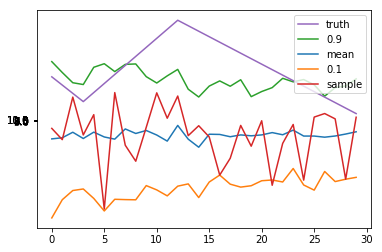

In [75]:
import matplotlib.pyplot as plt

month = 'March' # “He who controls the past controls the future. He who controls the present controls the past.”
year = 2013

prediction_data = buildPredictionData(month, year, trainingSet)

result = predictor.predict(prediction_data).encode('utf-8')

plotSeries(result, 
           truth=True, 
           truth_data=testSet["{} {}".format(month, year)][-prediction_length:], 
           truth_label='truth')